In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import re
from nltk.tokenize import RegexpTokenizer
import numpy as np
import sys

In [6]:
%%time

df = pd.read_csv('/content/drive/My Drive/nl2ml_data/code_blocks.csv', sep='\t', delimiter='\t',
                 encoding='utf-8', error_bad_lines=False, engine='python')

Skipping line 7662: field larger than field limit (131072)
Skipping line 24774: field larger than field limit (131072)
Skipping line 45491: field larger than field limit (131072)
Skipping line 53234: field larger than field limit (131072)
Skipping line 53235: field larger than field limit (131072)
Skipping line 53236: field larger than field limit (131072)
Skipping line 54382: field larger than field limit (131072)
Skipping line 60222: field larger than field limit (131072)
Skipping line 60223: field larger than field limit (131072)
Skipping line 60224: field larger than field limit (131072)
Skipping line 60225: field larger than field limit (131072)
Skipping line 60226: field larger than field limit (131072)
Skipping line 60227: field larger than field limit (131072)
Skipping line 60228: field larger than field limit (131072)
Skipping line 60229: field larger than field limit (131072)
Skipping line 60230: field larger than field limit (131072)
Skipping line 60231: field larger than fi

CPU times: user 3.45 s, sys: 441 ms, total: 3.89 s
Wall time: 5.7 s


In [7]:
print('origical df shape:', df.shape, '\nnumber of unique code blocks:', df['code_block'].nunique())
df.drop_duplicates(subset='code_block', inplace=True)
df.reset_index(drop=True)
print('new df shape:', df.shape)

origical df shape: (271587, 2) 
number of unique code blocks: 197216
new df shape: (197216, 2)


In [0]:
df.to_csv('/content/drive/My Drive/nl2ml_data/code_blocks_unique.csv', sep='\t', encoding='utf-8', index=False)

In [0]:
df = pd.read_csv('/content/drive/My Drive/nl2ml_data/code_blocks_unique.csv', sep='\t', delimiter='\t',
                 encoding='utf-8', error_bad_lines=False, engine='python')

In [10]:
df.head()

,code_block,tag
0,\nimport pandas as pd\nimport matplotlib.pyplo...,['invite people for the kaggle party']
1,"\ndf_train = pd.read_csv('../input/train.csv'),",['bring in the six packs']
2,"\ndf_train.columns,",['check the decoration']
3,"\ndf_train['SalePrice'].describe(),",['descriptive statistics summary']
4,"\nsns.distplot(df_train['SalePrice']);,",['histogram']


**TAGGING**

In [0]:
graph = {'imports': ['import ', ' from ']
          ,'data_load': ['.load', '_load', '_dump', 'load_', '.csv', 'glob', 'pickle.', 'read_', 'download', '.txt', '.json', '.png', '.jpg', '.jpeg']
          ,'preprocessing': ['train_test_split(', 'Normalizer(', 'StandardScaler(', 'normalize(', 'scale(', 'DictVectorizer(', 'CountVectorizer(', 'HashingVectorizer(', 'TfidfVectorizer(', 'Stemmer(', 'Lemmatizer(', 'convert', '.resize', 'encode(', '.fill(', '.fillna(', '.concat', 'merge'
                              ,'train_test_split (', 'Normalizer (', 'StandardScaler (', 'normalize (', 'scale (', 'DictVectorizer (', 'CountVectorizer (', 'HashingVectorizer (', 'TfidfVectorizer (', 'Stemmer (', 'Lemmatizer (', 'encode (', '.fill (', '.fillna (']
          ,'visualization': ['plot.', 'plt.', 'graph', 'histogram', 'hist', 'sns.', 'plotline', 'chart', 'diagram', 'heatmap', 'figure', 'plot_tree(', 'plot_tree (']
          ,'model': ['LinearRegression(', 'RandomForest(', 'Ridge(', 'RidgeCV(', 'RidgeClassifier(', 'RidgeClassifierCV(', 'Lasso(', 'SGD(', 'LogisticRegression(', 'LogisticRegressionCV(', 'SVC(', 'SVR(', 'Layer(', 'XGboost(', 'LGBM(', 'CatBoost('
                      , 'Perceptron(', 'KNeighborsRegressor(', 'KNeighborsClassifier(', 'SGDRegressor(', 'ElasticNet(', 'ElasticNetCV(', 'KMeans(', 'AgglomerativeClustering(', 'SpectralClustering(', 'CategoricalNB(', 'ComplementNB(', 'DecisionTreeClassifier(', 'DecisionTreeRegressor('
                      ,'LinearRegression (', 'RandomForest (', 'Ridge (', 'RidgeCV (', 'RidgeClassifier (', 'RidgeClassifierCV (', 'Lasso (', 'SGD (', 'LogisticRegression (', 'LogisticRegressionCV (', 'SVC (', 'SVR (', 'Layer (', 'XGboost (', 'LGBM (', 'CatBoost ('
                      , 'Perceptron (', 'KNeighborsRegressor (', 'KNeighborsClassifier (', 'SGDRegressor (', 'ElasticNet (', 'ElasticNetCV (', 'KMeans (', 'AgglomerativeClustering (', 'SpectralClustering (', 'CategoricalNB (', 'ComplementNB (', 'DecisionTreeClassifier (', 'DecisionTreeRegressor (']
          ,'train': ['.fit_transform', '.fit', 'epoch', 'loss', 'optimizer']
          ,'predict': ['.predict', '_error', '.mean_', '_score', '_distance']
}

In [0]:
def tokens_search(df, tokens, new_column_name):
    df[new_column_name] = 0
    for i in range(len(df)):
        for token in tokens:
            if token in df.loc[i, 'code_block']:
                df.at[i, new_column_name] = 1
                break
    return df

In [13]:
%%time

for i in range(0, len(graph)):
    vertex = list(graph.keys())[i]
    tokens = graph[vertex]
    df = tokens_search(df, tokens, vertex)

CPU times: user 3min, sys: 57.6 ms, total: 3min
Wall time: 3min


In [14]:
df.head()

,code_block,tag,imports,data_load,preprocessing,visualization,model,train,predict
0,\nimport pandas as pd\nimport matplotlib.pyplo...,['invite people for the kaggle party'],1,0,0,0,0,0,0
1,"\ndf_train = pd.read_csv('../input/train.csv'),",['bring in the six packs'],0,1,0,0,0,0,0
2,"\ndf_train.columns,",['check the decoration'],0,0,0,0,0,0,0
3,"\ndf_train['SalePrice'].describe(),",['descriptive statistics summary'],0,0,0,0,0,0,0
4,"\nsns.distplot(df_train['SalePrice']);,",['histogram'],0,0,0,1,0,0,0


In [15]:
stats = {'imports': f"{100 * df['imports'].value_counts()[1]/len(df):.2f}"
          ,'data_load': f"{100 * df['data_load'].value_counts()[1]/len(df):.2f}"
          ,'preprocessing': f"{100 * df['preprocessing'].value_counts()[1]/len(df):.2f}"
          ,'visualization': f"{100 * df['visualization'].value_counts()[1]/len(df):.2f}"
          ,'model': f"{100 * df['model'].value_counts()[1]/len(df):.2f}"
          ,'train': f"{100 * df['train'].value_counts()[1]/len(df):.2f}"
          ,'predict': f"{100 * df['predict'].value_counts()[1]/len(df):.2f}"
}

stats

{'data_load': '12.47',
 'imports': '12.99',
 'model': '2.60',
 'predict': '9.56',
 'preprocessing': '8.82',
 'train': '10.66',
 'visualization': '19.24'}

**SVM** for the 'imports' tag

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

In [0]:
X = df['code_block']
y = df['imports']

In [0]:
vectorizer = TfidfVectorizer(ngram_range = (1,2), smooth_idf = True)
X = vectorizer.fit_transform(X)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
grid = {"C": [1, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
model = SVC(kernel="linear", random_state=241)
gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)

In [18]:
%%time

gs.fit(X_train[:25000], y_train.ravel()[:25000])

C = gs.best_params_.get('C')

# total runtime:
# Fitting 5 folds for each of 3 candidates, totalling 15 fits
# [ Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 117.0min finished
# CPU times: user 8min 19s, sys: 1.09 s, total: 8min 20s
# Wall time: 2h 5min 18s

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 31.4min finished


CPU times: user 4min 27s, sys: 603 ms, total: 4min 27s
Wall time: 35min 49s


In [19]:
C

100

**LINEAR KERNEL**

In [20]:
%%time

# model = SVC(C=C, kernel="linear", random_state=241)
# model.fit(X_train, y_train.ravel())

# a faster option:
# 1: usage of BagginClassifier decreased the fitting time from 38 mins to 8
n_estimators = 10
clf = BaggingClassifier(SVC(C=C, kernel='linear', random_state=241), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
clf.fit(X_train, y_train.ravel())

CPU times: user 8min 48s, sys: 898 ms, total: 8min 49s
Wall time: 8min 49s


In [0]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [22]:
%%time

# y_pred = model.predict(X_test)
y_pred = clf.predict(X_test)

CPU times: user 16min 17s, sys: 2.01 s, total: 16min 19s
Wall time: 16min 16s


In [23]:
metrics.precision_score(y_test, y_pred)

0.9972805559752228

In [24]:
metrics.f1_score(y_test, y_pred)

0.9234750979294907

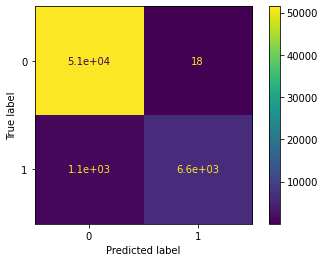

In [25]:
# metrics.plot_confusion_matrix(model, X_test, y_test)
metrics.plot_confusion_matrix(clf, X_test, y_test)

**SVM** for the 'data_load' tag

In [0]:
X = df['code_block']
y = df['data_load']

vectorizer = TfidfVectorizer(ngram_range = (1,2), smooth_idf = True)
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [27]:
%%time

grid = {"C": [1, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
model = SVC(kernel="linear", random_state=241)
gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)
gs.fit(X_train[:25000], y_train.ravel()[:25000])
C = gs.best_params_.get('C')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 36.2min finished


CPU times: user 6min 7s, sys: 388 ms, total: 6min 8s
Wall time: 42min 19s


In [28]:
C

100

In [29]:
%%time

n_estimators = 10
model = BaggingClassifier(SVC(C=C, kernel='linear', random_state=241), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
model.fit(X_train, y_train.ravel())

CPU times: user 13min 37s, sys: 673 ms, total: 13min 37s
Wall time: 13min 38s


In [30]:
%%time

y_pred = model.predict(X_test)

CPU times: user 18min 32s, sys: 2.05 s, total: 18min 34s
Wall time: 18min 31s


In [31]:
metrics.precision_score(y_test, y_pred)

0.9854039375424304

In [32]:
metrics.f1_score(y_test, y_pred)

0.869747584450603

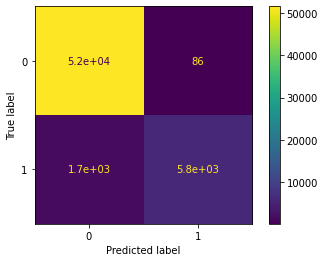

In [33]:
metrics.plot_confusion_matrix(model, X_test, y_test)

**SVM** for the 'preprocessing' tag

In [0]:
X = df['code_block']
y = df['preprocessing']

vectorizer = TfidfVectorizer(ngram_range = (1,2), smooth_idf = True)
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [35]:
%%time

grid = {"C": [1, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
model = SVC(kernel="linear", random_state=241)
gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)
gs.fit(X_train[:25000], y_train.ravel()[:25000])
C = gs.best_params_.get('C')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 44.1min finished


CPU times: user 7min 53s, sys: 427 ms, total: 7min 53s
Wall time: 51min 59s


In [36]:
C

100

In [37]:
%%time

n_estimators = 10
model = BaggingClassifier(SVC(C=C, kernel='linear', random_state=241), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
model.fit(X_train, y_train.ravel())

CPU times: user 19min 10s, sys: 731 ms, total: 19min 11s
Wall time: 19min 12s


In [38]:
%%time

y_pred = model.predict(X_test)

CPU times: user 22min 46s, sys: 3.48 s, total: 22min 50s
Wall time: 22min 45s


In [39]:
metrics.precision_score(y_test, y_pred)

0.9881782358290391

In [40]:
metrics.f1_score(y_test, y_pred)

0.7617712349573548

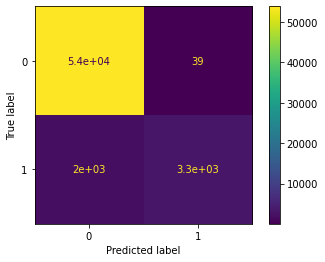

In [41]:
metrics.plot_confusion_matrix(model, X_test, y_test)

**SVM** for the 'visualization' tag

In [0]:
X = df['code_block']
y = df['visualization']

vectorizer = TfidfVectorizer(ngram_range = (1,2), smooth_idf = True)
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [43]:
%%time

grid = {"C": [1, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
model = SVC(kernel="linear", random_state=241)
gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)
gs.fit(X_train[:25000], y_train.ravel()[:25000])
C = gs.best_params_.get('C')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 42.1min finished


CPU times: user 7min 13s, sys: 473 ms, total: 7min 13s
Wall time: 49min 22s


In [44]:
C

10

In [45]:
%%time

n_estimators = 10
model = BaggingClassifier(SVC(C=C, kernel='linear', random_state=241), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
model.fit(X_train, y_train.ravel())

CPU times: user 19min 20s, sys: 822 ms, total: 19min 21s
Wall time: 19min 22s


In [46]:
%%time

y_pred = model.predict(X_test)

CPU times: user 24min 31s, sys: 3.91 s, total: 24min 35s
Wall time: 24min 30s


In [47]:
metrics.precision_score(y_test, y_pred)

0.9961192810457516

In [48]:
metrics.f1_score(y_test, y_pred)

0.9245935826342481

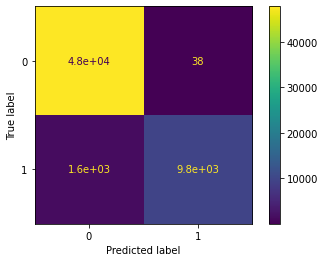

In [49]:
metrics.plot_confusion_matrix(model, X_test, y_test)

**SVM** for the 'model' tag

In [0]:
X = df['code_block']
y = df['model']

vectorizer = TfidfVectorizer(ngram_range = (1,2), smooth_idf = True)
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [51]:
%%time

grid = {"C": [1, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
model = SVC(kernel="linear", random_state=241)
gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)
gs.fit(X_train[:25000], y_train.ravel()[:25000])
C = gs.best_params_.get('C')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.9min finished


CPU times: user 1min 35s, sys: 313 ms, total: 1min 35s
Wall time: 7min 31s


In [52]:
C

100

In [53]:
%%time

n_estimators = 10
model = BaggingClassifier(SVC(C=C, kernel='linear', random_state=241), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
model.fit(X_train, y_train.ravel())

CPU times: user 3min 3s, sys: 301 ms, total: 3min 3s
Wall time: 3min 4s


In [54]:
%%time

y_pred = model.predict(X_test)

CPU times: user 7min 2s, sys: 1.12 s, total: 7min 3s
Wall time: 7min 2s


In [55]:
metrics.precision_score(y_test, y_pred)

0.9686450167973124

In [56]:
metrics.f1_score(y_test, y_pred)

0.7101806239737274

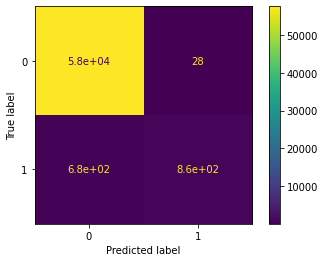

In [57]:
metrics.plot_confusion_matrix(model, X_test, y_test)

**SVM** for the 'train' tag

In [0]:
X = df['code_block']
y = df['train']

vectorizer = TfidfVectorizer(ngram_range = (1,2), smooth_idf = True)
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [59]:
%%time

grid = {"C": [1, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
model = SVC(kernel="linear", random_state=241)
gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=-1)
gs.fit(X_train[:25000], y_train.ravel()[:25000])
C = gs.best_params_.get('C')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 34.2min finished


CPU times: user 5min 46s, sys: 433 ms, total: 5min 46s
Wall time: 39min 59s


In [60]:
C

10

In [61]:
%%time

n_estimators = 10
model = BaggingClassifier(SVC(C=C, kernel='linear', random_state=241), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
model.fit(X_train, y_train.ravel())

CPU times: user 13min 9s, sys: 582 ms, total: 13min 10s
Wall time: 13min 11s


In [62]:
%%time

y_pred = model.predict(X_test)

CPU times: user 19min 42s, sys: 3.17 s, total: 19min 46s
Wall time: 19min 41s


In [63]:
metrics.precision_score(y_test, y_pred)

0.9813664596273292

In [65]:
metrics.f1_score(y_test, y_pred)

0.8833755569144754

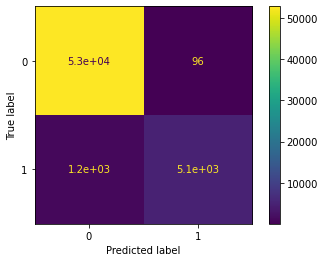

In [64]:
metrics.plot_confusion_matrix(model, X_test, y_test)

**SVM** for the 'predict' tag

In [0]:
X = df['code_block']
y = df['predict']

vectorizer = TfidfVectorizer(ngram_range = (1,2), smooth_idf = True)
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
%%time

grid = {"C": [1, 10, 100]}
cv = KFold(n_splits=5, shuffle=True, random_state=241)
model = SVC(kernel="linear", random_state=241)
gs = GridSearchCV(model, grid, scoring="accuracy", cv=cv, verbose=1, n_jobs=1)
gs.fit(X_train[:25000], y_train.ravel()[:25000])  # n = 25k caused memory leaks + n_jobs=-1, so it did with n = 20k
C = gs.best_params_.get('C')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 41.6min finished


CPU times: user 46min, sys: 1.78 s, total: 46min 1s
Wall time: 46min 3s


In [22]:
C

100

In [23]:
%%time

n_estimators = 10
model = BaggingClassifier(SVC(C=C, kernel='linear', random_state=241), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
model.fit(X_train, y_train.ravel())

CPU times: user 8min 55s, sys: 771 ms, total: 8min 55s
Wall time: 8min 56s


In [24]:
%%time

y_pred = model.predict(X_test)

CPU times: user 15min 31s, sys: 1.04 s, total: 15min 32s
Wall time: 15min 31s


In [25]:
metrics.precision_score(y_test, y_pred)

0.9709090909090909

In [26]:
metrics.f1_score(y_test, y_pred)

0.8147696063472689

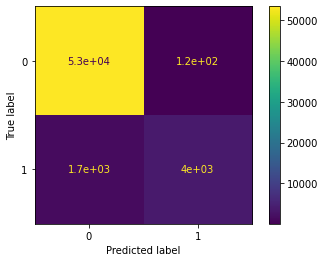

In [27]:
metrics.plot_confusion_matrix(model, X_test, y_test)